In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import sys
import csv
import pandas as pd
import sys
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from joblib import dump
from collections import Counter
from gensim.models import KeyedVectors

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\teode\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\teode\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
def get_wordnet_pos(treebank_tag):
    """ Convert Treebank tags to WordNet tags """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN

def extract_features_and_labels(file_path, include_embeddings=True, drop_columns=[]):
    data = []
    targets = []
    lemmatizer = WordNetLemmatizer()
    word_vectors = KeyedVectors.load_word2vec_format("embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)

    with open(file_path, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) == 10:
                token, preceding_token, next_token, lemma, capitalization, word_shape, word_length, pos_tag, chunk_label, gold_label = components

                # Prepare embeddings only if needed
                embedding_features = {}
                if include_embeddings:
                    # Get embedding if available, else use a zero vector
                    embedding = word_vectors[token] if token in word_vectors else [0]*300
                    embedding_features = {f'emb_{i}': emb for i, emb in enumerate(embedding)}

                feature_dict = {
                    'OriginalWord': token,
                    'PreviousWord': preceding_token,
                    'NextWord': next_token,
                    'Lemma': lemma,
                    'Capitalization': capitalization,
                    'WordShape': word_shape,
                    'WordLength': str(word_length),
                    'POS': pos_tag,
                    'ChunkTag': chunk_label
                }

                # Add embedding features if they are to be included
                feature_dict.update(embedding_features)

                # Drop specified columns
                for col in drop_columns:
                    feature_dict.pop(col, None)

                data.append(feature_dict)
                targets.append(gold_label)

    return data, targets

def create_classifier(train_features, train_targets, model_name):
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)

    if model_name == 'logreg':
        model = LogisticRegression(max_iter=10000, C=0.1)
    elif model_name == 'NB':
        model = MultinomialNB()
    elif model_name == 'SVM':
        model = SVC(probability=True)
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    model.fit(features_vectorized, train_targets)
    return model, vec

def classify_and_evaluate(model, vec, test_features, test_labels):
    features_vectorized = vec.transform(test_features)
    predictions = model.predict(features_vectorized)
    print(classification_report(test_labels, predictions))
    return predictions


    

In [3]:
training_file = "data/pre.conll2003.train.conll"
dev_file = "data/pre.conll2003.dev.conll"

In [7]:

# Feature list (modify this with your actual feature names)
features = ['OriginalWord', 'PreviousWord', 'NextWord', 'Lemma', 'Capitalization', 
            'WordShape', 'WordLength', 'POS', 'ChunkTag']

In [6]:
# Extract features and labels from the training and development files
print("extracting train")
train_features, train_labels = extract_features_and_labels(training_file, include_embeddings=True, drop_columns=["POS", "WordShape", "WordLenght"])
print("extracting dev")
dev_features, dev_labels = extract_features_and_labels(dev_file, include_embeddings=True,drop_columns=["POS", "WordShape", "WordLenght"])

extracting train
extracting dev


Training and evaluating SVM...
Model evaluation completed. F1 Score: 0.9034070937420599
Confusion Matrix:
[[1648   11   97   31   10    1   14    9    6]
 [  25  770   33   16    0   22   11    9   28]
 [  91   33 1052   48    6    2   71   26    6]
 [  27   16   24 1651    2    1    6   87    4]
 [   7    0    3    2  212    4   17    8    4]
 [   4   28    7    5    3  241   19    9   26]
 [  31   10   38    9   30   11  547   20   52]
 [   9    5    7   57    3    1   11 1189   12]
 [   4   15   26    4    1   17   21    5 5116]]


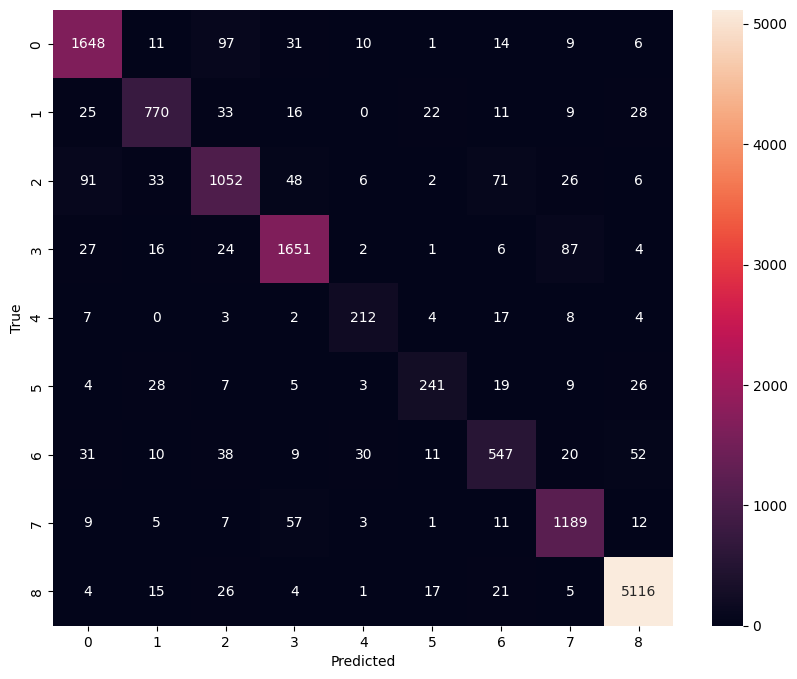

Detailed Error Analysis Report:
              precision    recall  f1-score   support

       B-LOC       0.89      0.90      0.90      1827
      B-MISC       0.87      0.84      0.85       914
       B-ORG       0.82      0.79      0.80      1335
       B-PER       0.91      0.91      0.91      1818
       I-LOC       0.79      0.82      0.81       257
      I-MISC       0.80      0.70      0.75       342
       I-ORG       0.76      0.73      0.75       748
       I-PER       0.87      0.92      0.90      1294
           O       0.97      0.98      0.98      5209

    accuracy                           0.90     13744
   macro avg       0.85      0.84      0.85     13744
weighted avg       0.90      0.90      0.90     13744



In [24]:


def train_and_evaluate_svm(train_features, train_labels, dev_features, dev_labels, model_path):
    print("Training and evaluating SVM...")
    vec = DictVectorizer()
    X_train = vec.fit_transform(train_features)
    X_dev = vec.transform(dev_features)

    model = SVC(C=1, gamma=0.001, kernel='linear', class_weight="balanced")
    model.fit(X_train, train_labels)

    predictions = model.predict(X_dev)
    f1 = f1_score(dev_labels, predictions, average='weighted')
    print(f"Model evaluation completed. F1 Score: {f1}")

    # Save the model and the vectorizer
    dump(model, model_path + 'svm_model.joblib')
    dump(vec, model_path + 'vectorizer.joblib')

    # Generate and analyze confusion matrix
    cm = confusion_matrix(dev_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

    # Plotting confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Detailed error analysis
    error_analysis_report = classification_report(dev_labels, predictions)
    print("Detailed Error Analysis Report:")
    print(error_analysis_report)

    return f1

# Call the function with necessary parameters
f1_score = train_and_evaluate_svm(train_features, train_labels, dev_features, dev_labels, 'models/best_SVC.joblib')
